# The Deterministic Cake Eating Problem - Value Function Iteration Solution
### by [Jason DeBacker](http://jasondebacker.com), November 2021
This Jupyter notebook illustrates how to solve the deterministic cake eating problem using value function iteration (VFI).


## The Problem:

$$V(w)=\max_{c} u(c)+\beta V(w'), \forall w\in[0,\bar{w}]$$

or, substituting in the law of motion: $w' = w - c$,

$$V(w)=\max_{0\leq w' \leq w}u(w-w')+\beta V(w'), \forall w$$

The unknowns in this system are functions: The value function, $V(w)$, and the policy function, $c = \phi(w)$ (or, equivalently, $w' = p(w)$).

## The Solution:

We'll solve this problem with value function iteration (VFI).  With this method, we'll use an iterative procedure to converge to a fixed point in function space, the true value function, $V(w)$.  

The computational algorithm for VFI is as follows:

1. Create a discrete grid of the state variable, $w$
2. Make an initial guess at the value function, $V_{0}(w)$
    * This will be a value for each point in the state space
3. Perform the operation:
$$TV(w) = \max_{w'}u(w-w') + \beta V_{0}(w')$$
4. Update the guess at the value function: $V_{1}(w) = TV(w)$
5. Repeat this process:
$$V_{i+1} \ (w) = TV(w) = \max_{w'}u(w-w') + \beta V_{i}(w)$$
6. Stop when, $|V_{i+1} \ (w)-V_{i}(w)|<\varepsilon$, where $\varepsilon$ is a small number.


In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# to print plots inline
%matplotlib inline

## Step 1: Set parameter values

Parameters:
* $\beta$ = rate of time preference
* $\sigma$ = coefficient of relative risk aversion (if $\sigma = 1$, $u(c)=log(c)$), parameter describes the curvature of the utility function

In [2]:
beta = 0.95
sigma = 1.0
R = 1

## Step 2: Create Grid Space
We will solve this model over a discrete grid.  So we'll set a grid with a finite number of points, each of which represent an amount of cake.

We'll also want to know the flow utility from consuming each amount of cake that is possible given this grid.

In [3]:
'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_w      = scalar, lower bound of cake grid
ub_w      = scalar, upper bound of cake grid 
size_w    = integer, number of grid points in cake state space
w_grid    = vector, size_w x 1 vector of cake grid points 
------------------------------------------------------------------------
'''
lb_w = 0.4 
ub_w = 2.0 
size_w = 400  # Number of grid points
w_grid = np.linspace(lb_w, ub_w, size_w)

'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption (c=w-w')
U        = matrix, current period utility value for all possible
           choices of w and w' (rows are w, columns w')
------------------------------------------------------------------------
'''
C = np.zeros((size_w, size_w)) 
for i in range(size_w): # loop over w
    for j in range(size_w): # loop over w'
        C[i, j] = w_grid[i] - w_grid[j] / R # note that if w'>w, consumption negative
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-15
if sigma == 1:
    U = np.log(C)
else:
    U = (C ** (1 - sigma)) / (1 - sigma)
U[C<0] = -9999999

## Step 3: Value Function Iteration

In [7]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of w and w'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of w' for all w 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 7.0 
VFmaxiter = 3000 
V = np.zeros(size_w) # initial guess at value function
Vmat = np.zeros((size_w, size_w)) # initialize Vmat matrix
Vstore = np.zeros((size_w, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:  
    for i in range(size_w): # loop over w
        for j in range(size_w): # loop over w'
            Vmat[i, j] = U[i, j] + beta * V[j] 
      
    Vstore[:, VFiter] = V.reshape(size_w,) # store value function at each iteration for graphing later
    TV = Vmat.max(1) # apply max operator to Vmat (to get V(w))
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 
    


if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 395


## Step 4: Extract decision rules from solution

In [8]:
'''
------------------------------------------------------------------------
Find consumption and savings policy functions   
------------------------------------------------------------------------
optW  = vector, the optimal choice of w' for each w
optC  = vector, the optimal choice of c for each c
------------------------------------------------------------------------
'''
optW = w_grid[PF] # tomorrow's optimal cake size (savings function)
optC = w_grid - optW # optimal consumption - get consumption through the transition eqn


## Visualize output

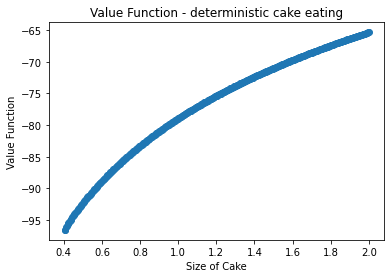

In [6]:
# Plot value function 
plt.figure()
plt.scatter(w_grid[1:], VF[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic cake eating')
plt.show()

<Figure size 432x288 with 0 Axes>

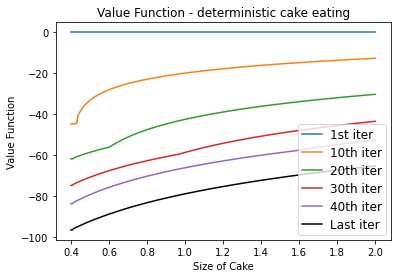

In [7]:
# Plot value function at several iterations
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid, Vstore[:,0], label='1st iter')
ax.plot(w_grid, Vstore[:,10], label='10th iter')
ax.plot(w_grid, Vstore[:,20], label='20th iter')
ax.plot(w_grid, Vstore[:,30], label='30th iter')
ax.plot(w_grid, Vstore[:,40], label='40th iter')
ax.plot(w_grid, Vstore[:,VFiter-1], 'k', label='Last iter')
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic cake eating')
plt.show()

<Figure size 432x288 with 0 Axes>

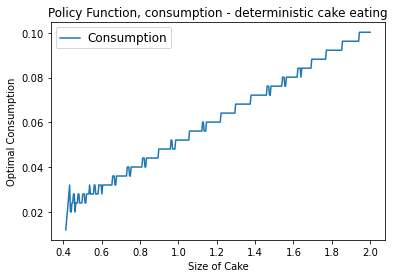

In [8]:
#Plot optimal consumption rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[3:], optC[3:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption - deterministic cake eating')
plt.show()

<Figure size 432x288 with 0 Axes>

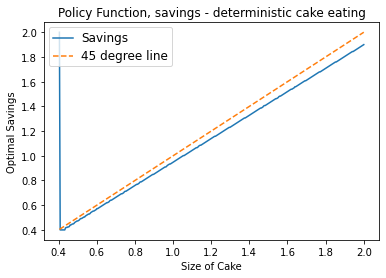

In [9]:
#Plot cake to leave rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], optW[1:], label='Savings')
ax.plot(w_grid[1:], w_grid[1:], '--', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Savings')
plt.title('Policy Function, savings - deterministic cake eating')
plt.show()

## Finding approximation errors

It's a little complicated (we need to do the guess and verify method), but we can show that with $\sigma = 1.0$ (i.e., $u(c) = log(c)$), then the policy function is $w' = \beta w$.  Knowing this, we can find the approximation error from our solution method (VFI over a discrete grid).  This errors are found as:

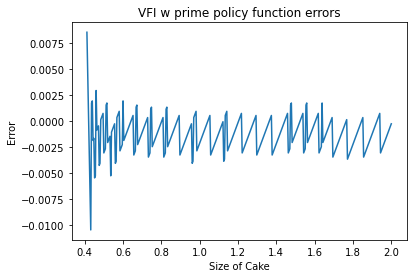

In [10]:
Wprime_errors = optW - beta * w_grid

# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[3:], Wprime_errors[3:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI w prime policy function errors')
plt.show()

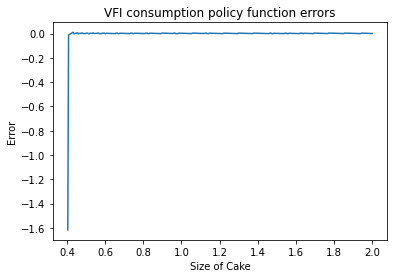

In [11]:
C_errors = optC - (1 - beta) * w_grid
# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[1:], C_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI consumption policy function errors')
plt.show()

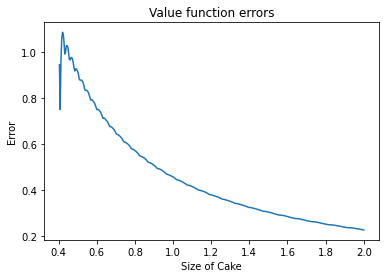

In [12]:
# Compute true value function if u(c)=log(c)
B = 1 / (1 - beta)
A = B * np.log(1 - beta) + B * B * beta * np.log(R * beta)
true_VF = A + B * np.log(w_grid)
VF_errors = VF - true_VF
# Plot value function approximation errors
plt.figure()
plt.plot(w_grid[1:], VF_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('Value function errors')
plt.show()

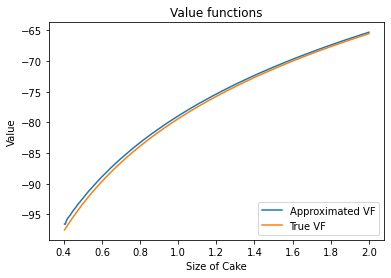

In [13]:
# Plot true and found value functions
plt.figure()
plt.plot(w_grid[1:], VF[1:], label='Approximated VF')
plt.plot(w_grid[1:], true_VF[1:], label='True VF')
plt.xlabel('Size of Cake')
plt.ylabel('Value')
plt.title('Value functions')
plt.legend(loc='lower right')
plt.show()